In [160]:
import pandas as pd
import matplotlib
import numpy as np
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

In [3]:
df_acct = pd.read_csv('data-set/completedacct.csv')
df_card = pd.read_csv('data-set/completedcard.csv')
df_client = pd.read_csv('data-set/completedclient.csv')
df_disposition = pd.read_csv('data-set/completeddisposition.csv')
df_district = pd.read_csv('data-set/completeddistrict.csv')
df_loan = pd.read_csv('data-set/completedloan.csv')
df_order = pd.read_csv('data-set/completedorder.csv')
df_trans = pd.read_csv('data-set/completedtrans.csv', low_memory=False)
# df_crm_call = pd.read_csv('data-set/CRM Call Center Logs.csv')
# df_crm_events = pd.read_csv('data-set/CRM Events.csv')
# df_crm_reviews = pd.read_csv('data-set/CRM Reviews.csv')
df_luxury_loans = pd.read_csv('data-set/LuxuryLoanPortfolio.csv')

# Level 1: Exploring (1 point per task)

1. What are the different durations that loans are taken in and how many loans are taken for each duration?

In [7]:
different_durations_amounts = df_loan.duration.value_counts()
print(different_durations_amounts)



60    145
24    138
48    138
12    131
36    130
Name: duration, dtype: int64


2. What are the different statuses for the loans?

In [8]:
different_statuses = df_loan.status.unique()
print(different_statuses)

['A' 'C' 'B' 'D']


3. What are the different loan purposes and what is the most common purpose?

In [13]:
different_purposes = df_loan.purpose.unique()
print(different_purposes)
most_common_purpose = df_loan.purpose.mode()
print(most_common_purpose)

['car' 'debt_consolidation' 'home_improvement' 'home']
0    home
Name: purpose, dtype: object


4. What is the median loan amount?

In [14]:
median_loan_amount = df_loan.amount.median()
print(median_loan_amount)

116928.0


5. How is the median loan amount changing over the years? Visualize this

<AxesSubplot:xlabel='year'>

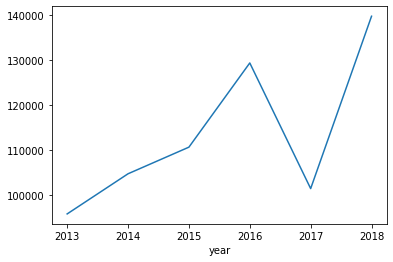

In [35]:
average_amount_by_year = df_loan.amount.groupby(df_loan.year).median()
average_amount_by_year.plot()

6. What are the top 3 most common locations that people take loans in? (The location is represented by a
number)

In [28]:
most_common_locations = df_loan.location.value_counts()[:3]
print(most_common_locations)

1     507
64     75
59     55
Name: location, dtype: int64


7. What is the average value of loans for each duration? Visualize this.

duration
12     53635.511450
24     99217.913043
36    144048.184615
48    205592.695652
60    244450.758621
Name: amount, dtype: float64


<AxesSubplot:xlabel='duration'>

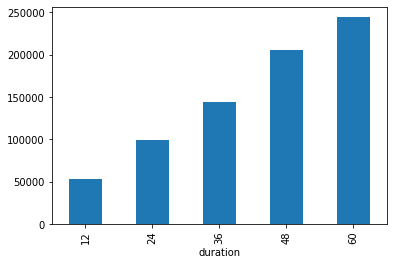

In [32]:
average_by_duration = df_loan.amount.groupby(df_loan.duration).mean()
print(average_by_duration)
average_by_duration.plot.bar()

# Level 2: Analyzing (3 points per task)

1. How many of the loans taken are by males and how many of them are by females?

In [110]:
owners_only = df_disposition[df_disposition['type'] == 'Owner']
# loans_with_accounts = df_loan.set_index('account_id').join(owners_only.set_index('account_id'), how='left')
# loans_with_clients = loans_with_accounts.set_index('client_id').join(df_client.set_index('client_id'), rsuffix='client_id', lsuffix='client_id', how='left')
loans_with_accounts = df_loan.merge(owners_only, how='left', on='account_id')
loans_with_clients = loans_with_accounts.merge(df_client, how='left', on='client_id')

removing_duplicates = loans_with_clients.set_index('loan_id').drop_duplicates('client_id')
loans_with_clients.sex.value_counts()

Female    348
Male      334
Name: sex, dtype: int64

2. Create categories for the ages of the clients
    
    a. <25 
    b. 25-35 
    c. 35-45 
    d. 50-65 
    e. >65

In [112]:
bins = [0, 25, 35, 50, 65, np.inf]
labels = ['a','b','c','d','e']
# age_categories = pd.cut(df_client.age, bins=bins)
# age_categories.value_counts()

df_client['age_category'] = pd.cut(df_client.age, bins=bins, labels=labels)

,client_id,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id,age_category
0,C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,b
1,C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1,d
2,C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1,d
3,C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,c
4,C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,d
5365,C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1,d
5366,C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,b
5367,C00013971,Female,1982-10-19,19,10,1982,37,278-77-3298,Ruth,Joy,Martin,856-636-3840,ruth.martin@gmail.com,7087 E. Pennsylvania Street,Unit 8,Danbury,CT,48475,67,c


3. Check which age group has the highest count of loans? Visualize this

<AxesSubplot:>

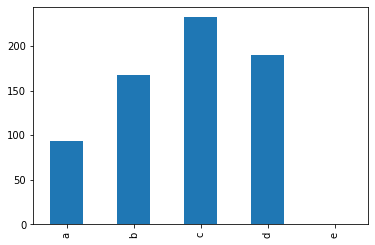

In [122]:
loans_with_clients['age_group'] = pd.cut(loans_with_clients.age, bins=bins, labels=labels)
loans_with_clients.age_group.value_counts().sort_index().plot.bar()


4. Check which age group has the highest value of loans? Visualize this

<AxesSubplot:xlabel='age_group'>

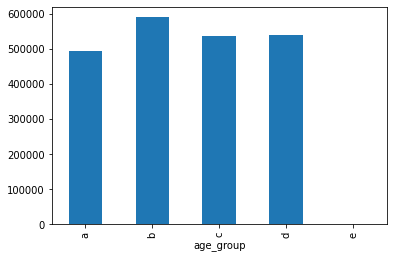

In [124]:
max_amounts = loans_with_clients.groupby('age_group')
max_amounts.amount.max().plot.bar()

5. Create categories for the loan “amounts”:
    a. '-75K'
    b. '75K-150K'
    c. '150K-250K' 
    d. '250K-350K'
    e. '350K+

In [135]:
amount_bins = [0, 75000, 150000, 250000, 350000, np.inf]
amount_labels = ['a','b','c','d','e']

amount_categories = pd.cut(df_loan.amount, bins=amount_bins, labels=amount_labels)
amount_categories.value_counts()

a    206
b    189
c    161
d     78
e     48
Name: amount, dtype: int64

6. What are the different frequencies for loan payments?

In [220]:
print(df_loan.duration.div(12).value_counts())
# number_of_payments = df_loan.amount.div(df_loan.payments).div(df_loan.duration)
# payments_bins = [0, 1/12, 2/12, 4/12, 6/12, 1, 2, 26/12, 52/12]
# payments_labels = ['annually','semi-annual','quarterly','bi-monthy','monthly', 'semi-monthly', 'bi-weekly', 'weekly']
# payments_categories = pd.cut(number_of_payments, bins=payments_bins, labels=payments_labels)
# payments_categories.value_counts()

5.0    145
2.0    138
4.0    138
1.0    131
3.0    130
Name: duration, dtype: int64


# Level 3: Modeling

1. Create a model to predict the transaction purpose (10 points)
    
    a. Try out at least 3 different models, and comment on why you chose these models 
    
    b. Measure accuracy (at least one model should have accuracy of 80% or higher)

Clean up data before modelling

In [198]:
loan_data = pd.read_csv('data-set/completedloan.csv')
del loan_data['loan_id']
del loan_data['account_id']
del loan_data['fulldate']
purpose = loan_data.purpose
predict = 'purpose'

X = loan_data.drop([predict], 1)

le = preprocessing.LabelEncoder()
X['status'] = le.fit_transform(X.status.values)

y = purpose

classes = purpose.unique()


/var/folders/0m/yz0zvmgd5p9cy9bpc347rm880000gn/T/ipykernel_8957/4243839992.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = loan_data.drop([predict], 1)


Get our selector and divide the data

In [199]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=6)
selector.fit_transform(X, y)

params = selector.get_support()


new_X = X[X.columns[params]]


x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(new_X, y, test_size=0.3, stratify=y, shuffle=True)

Get the classifier

Random Forest Classifier

In [211]:
clf = ensemble.RandomForestClassifier(n_estimators=250, max_depth=5)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)

print(acc * 100)

88.78048780487805


SVM linear SVC using one vs rest classifier to make it a multi-class classifier

In [210]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.LinearSVC(random_state=0))
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)

print(acc * 100)


4.390243902439024


/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


K neighbors classifier

In [209]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)


acc = metrics.accuracy_score(y_test, y_pred)
print(acc * 100)

87.3170731707317


I chose Random Forest Classifier, SVM linear SVC using one vs rest classifier, and K neighbors classifier. Since the data we're trying to predict is a multi class data.

2. Create a model to predict the transaction "amount category" (10 points)
    a. Try out at least 3 different models, and comment on why you chose these models 
    b. Measure accuracy (at least one model should have accuracy of 80% or higher)

Clean up data before modelling

In [264]:
loan_data = pd.read_csv('data-set/completedloan.csv')

amount_bins = [0, 75000, 150000, 250000, 350000, np.inf]
amount_labels = ['a','b','c','d','e']

loan_data['amount_category'] = pd.cut(df_loan.amount, bins=amount_bins, labels=amount_labels)

del loan_data['loan_id']
del loan_data['account_id']
del loan_data['fulldate']



amount_category = loan_data.amount_category
predict = 'amount_category'

X = loan_data.drop([predict], 1)

le = preprocessing.LabelEncoder()
X['status'] = le.fit_transform(X.status.values)
X['purpose'] = le.fit_transform(X.purpose.values)
y = amount_category

classes = amount_category.unique()



/var/folders/0m/yz0zvmgd5p9cy9bpc347rm880000gn/T/ipykernel_8957/662360179.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = loan_data.drop([predict], 1)


Get our selector and divide the data

In [265]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=5)
selector.fit_transform(X, y)

params = selector.get_support()


new_X = X[X.columns[params]]


x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(new_X, y, test_size=0.3, stratify=y, shuffle=True)

Get the classifier

Random Forest Classifier

In [248]:
clf = ensemble.RandomForestClassifier(n_estimators=50, max_depth=3)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)

print('The accurary is: {}'.format(acc * 100))

The accurary is: 82.92682926829268


SVM linear SVC using one vs rest classifier to make it a multi-class classifier

In [249]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.LinearSVC(random_state=0))
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)

print('The accurary is: {}'.format(acc * 100))

The accurary is: 36.09756097560975


/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/faaatman/Desktop/GulfBank-Datathon/Datathon/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear fa

K neighbors classifier

In [266]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=15, leaf_size=12, p=5)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)


acc = metrics.accuracy_score(y_test, y_pred)
print('The accurary is: {}'.format(acc * 100))

The accurary is: 98.53658536585365


We chose Random Forest Regression since it gave the best accuracy and K neighbors was over fitting.